In [ ]:
!pip install geopandas==0.8.2
!pip install --upgrade pyshp
!pip install shapely  ==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda
!pip install pysal

     |████████████████████████████████| 962 kB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 22.4 MB/s 
     |████████████████████████████████| 6.3 MB 11.3 MB/s 
     |████████████████████████████████| 44 kB 1.6 MB/s 
ERROR: Invalid requirement: '==1.7.0'
     |████████████████████████████████| 2.4 MB 10.2 MB/s 
     |████████████████████████████████| 95 kB 3.9 MB/s 
     |████████████████████████████████| 209 kB 43.0 MB/s 
     |████████████████████████████████| 60 kB 6.9 MB/s 
     |████████████████████████████████| 269 kB 58.2 MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379095 sha256=b5c600d06d991ec2e93234c0bb746155dcc483cfa34ff35bb371da812b1e69de
  Stored in directory: /root/.cache/pip/wheels/a9/33/82/a0dde6150f4719939514a575369d4b49f89f5525feabc6d997
  Created wheel for splot: filename=splot-1.1.3-py3-none-any.whl size=37888 sha256=8fbf0e6033520f3e41f6fe8ba99c8eb01e406746846a4379e8e9312d076abd25
  Stored in directory: /root/.c

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# links com arquivos úteis
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/'
link_p = 'https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/'

## Dados da microrregião de Varginha

In [2]:
# ler dados de interesse
dados = pd.read_csv('https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/imrs-pam.csv', encoding='latin1')
# ler shapefile
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/mg.json'
geodf = gp.read_file(link)
# mesclar shapefile com dataframe
# usando a coluna mun
geodf.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)  # mudar nome da coluna com cód. para 'mun'
geodf['mun'] = geodf.mun.astype(int)  # transformar códigos em inteiros
mg = pd.merge(geodf, dados, on='mun', suffixes=('', '_y'))  # mesclar o dataframe e o shapefile
# tirar a primeira coluna
mg = mg.drop(columns='NM_MUNICIP', axis=1)

In [3]:
# para evitar alguns problemas com os nomes: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
mg = mg.to_crs(epsg=3395)

In [4]:
mg.head()

,mun,geometry,nome_mun,meso,nome_meso,micro,nome_micro,popul,area,tot_f_meio_sm,...,cana_a,feijao_a,milho_a,soja_a,banana_p,cafe_p,cana_p,feijao_p,milho_p,soja_p
0,3100104,"POLYGON ((-5279846.985 -2043606.659, -5279112....",Abadia dos Dourados,3105,Triângulo Mineiro/Alto Paranaíba,31019,Patrocínio,7037,881.1,685,...,11,5,1220,2850,9000,1200,41545,400,6570,3960
1,3100203,"POLYGON ((-5024883.779 -2165679.420, -5027160....",Abaeté,3106,Central Mineira,31024,Três Marias,23574,1817.1,2259,...,190,0,1485,385,5000,3000,50000,0,4215,4519
2,3100302,"POLYGON ((-4710006.581 -2275246.635, -4711282....",Abre Campo,3112,Zona da Mata,31061,Manhuaçu,13726,470.6,1896,...,300,480,400,0,5333,1200,30000,613,3000,0
3,3100401,"POLYGON ((-4789395.189 -2306796.330, -4790393....",Acaiaca,3112,Zona da Mata,31060,Ponte Nova,4061,101.9,796,...,45,50,92,0,7500,1000,31111,580,3000,0
4,3100500,"POLYGON ((-4715725.509 -2132337.652, -4716202....",Açucena,3108,Vale do Rio Doce,31039,Ipatinga,10066,815.4,1691,...,100,152,250,0,6000,714,30000,737,3300,0


In [5]:
# microrregião de interesse
vga = mg.query('nome_micro == "Varginha"')

In [6]:
vga.shape

(16, 71)

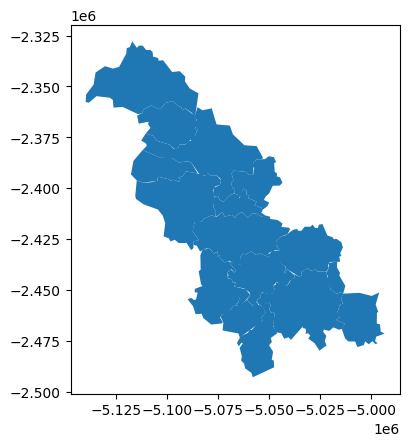

In [7]:
# visualizar mapa
vga.plot();

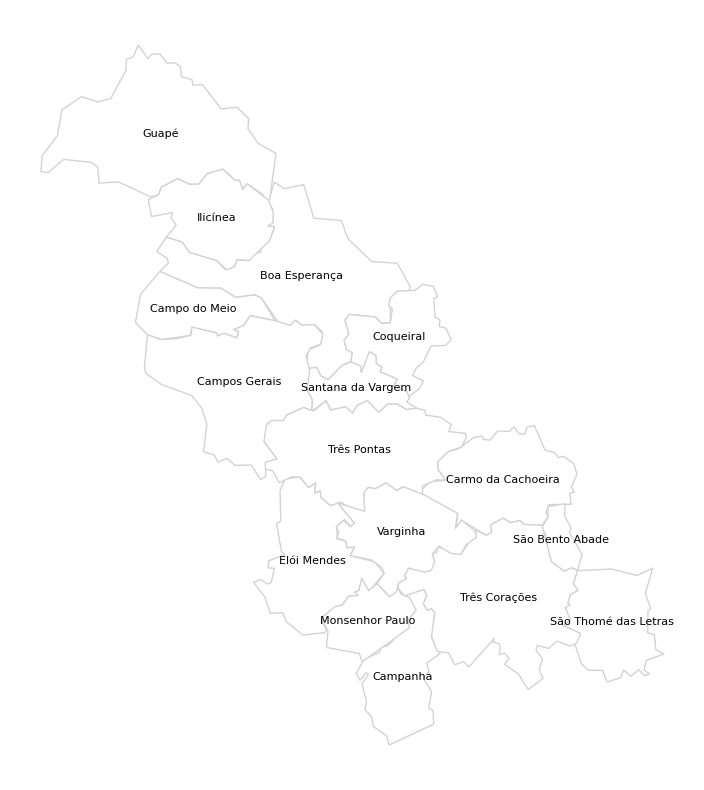

In [8]:
ax = vga.plot(color='white', edgecolor='lightgray', figsize=(10,10))

for i in vga.index:
    plt.text(vga.geometry.centroid[i].coords[0][0], vga.geometry.centroid[i].coords[0][1], vga.nome_mun[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center')

ax.set_axis_off();

In [9]:
# variável de interesse
variavel = 'popul'

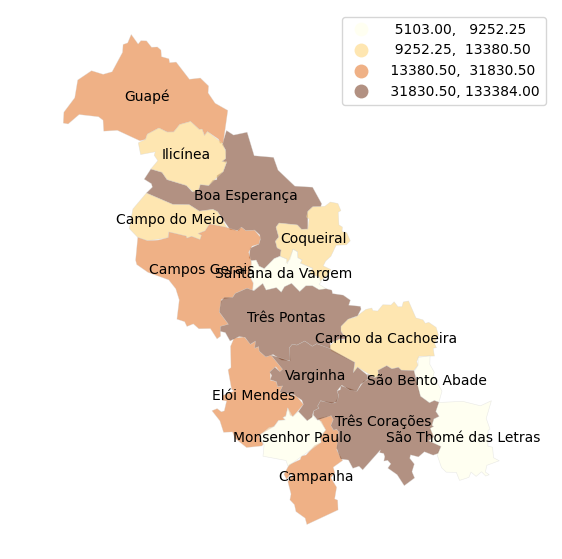

In [10]:
ax = vga.plot(variavel, cmap='YlOrBr', edgecolor='lightgray', linewidth=0.4, alpha=.5, figsize=(7,7), scheme='quantiles', k=4, legend=True)

fontdict = dict(color='black', size=10)

for i in vga.index:
    plt.text(vga.geometry.centroid[i].coords[0][0], vga.geometry.centroid[i].coords[0][1], vga.nome_mun[i],
             fontdict=fontdict, horizontalalignment='center', verticalalignment='center')

plt.axis('equal')
ax.set_axis_off();

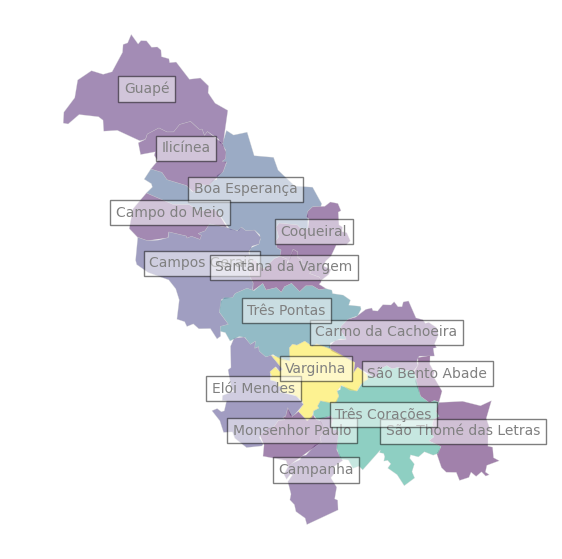

In [11]:
ax = vga.plot(variavel, cmap='viridis', edgecolor='lightgray', linewidth=0.4, alpha=.5, figsize=(7,7))

fontdict = dict(color='gray', size=10)
bboxdict = dict(facecolor='white', alpha=0.5)

for i in vga.index:
    plt.text(vga.geometry.centroid[i].coords[0][0], vga.geometry.centroid[i].coords[0][1], vga.nome_mun[i],
             horizontalalignment ='center', verticalalignment='bottom', fontdict=fontdict, bbox=bboxdict)

plt.axis('equal')
ax.set_axis_off();

In [12]:
# escolhendo algumas cidades manualmente
cidades_escolhidas = vga.query('nome_mun == ["Varginha", "Três Pontas", "Três Corações"]')

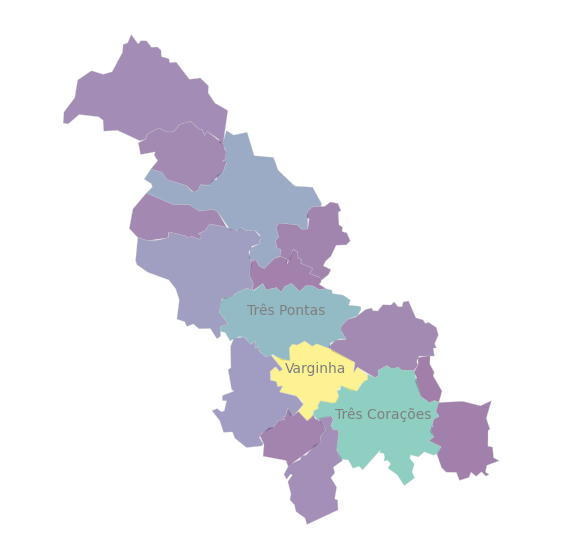

In [13]:
ax = vga.plot(variavel, cmap='viridis', edgecolor='lightgray', linewidth=0.4, alpha=.5, figsize=(7,7))

fontdict = dict(color='gray', size=10)

for i in cidades_escolhidas.index:
    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1],
             cidades_escolhidas.nome_mun[i],
             fontdict=fontdict, horizontalalignment='center', verticalalignment='bottom')

plt.axis('equal')
ax.set_axis_off();

**Estado de MG**

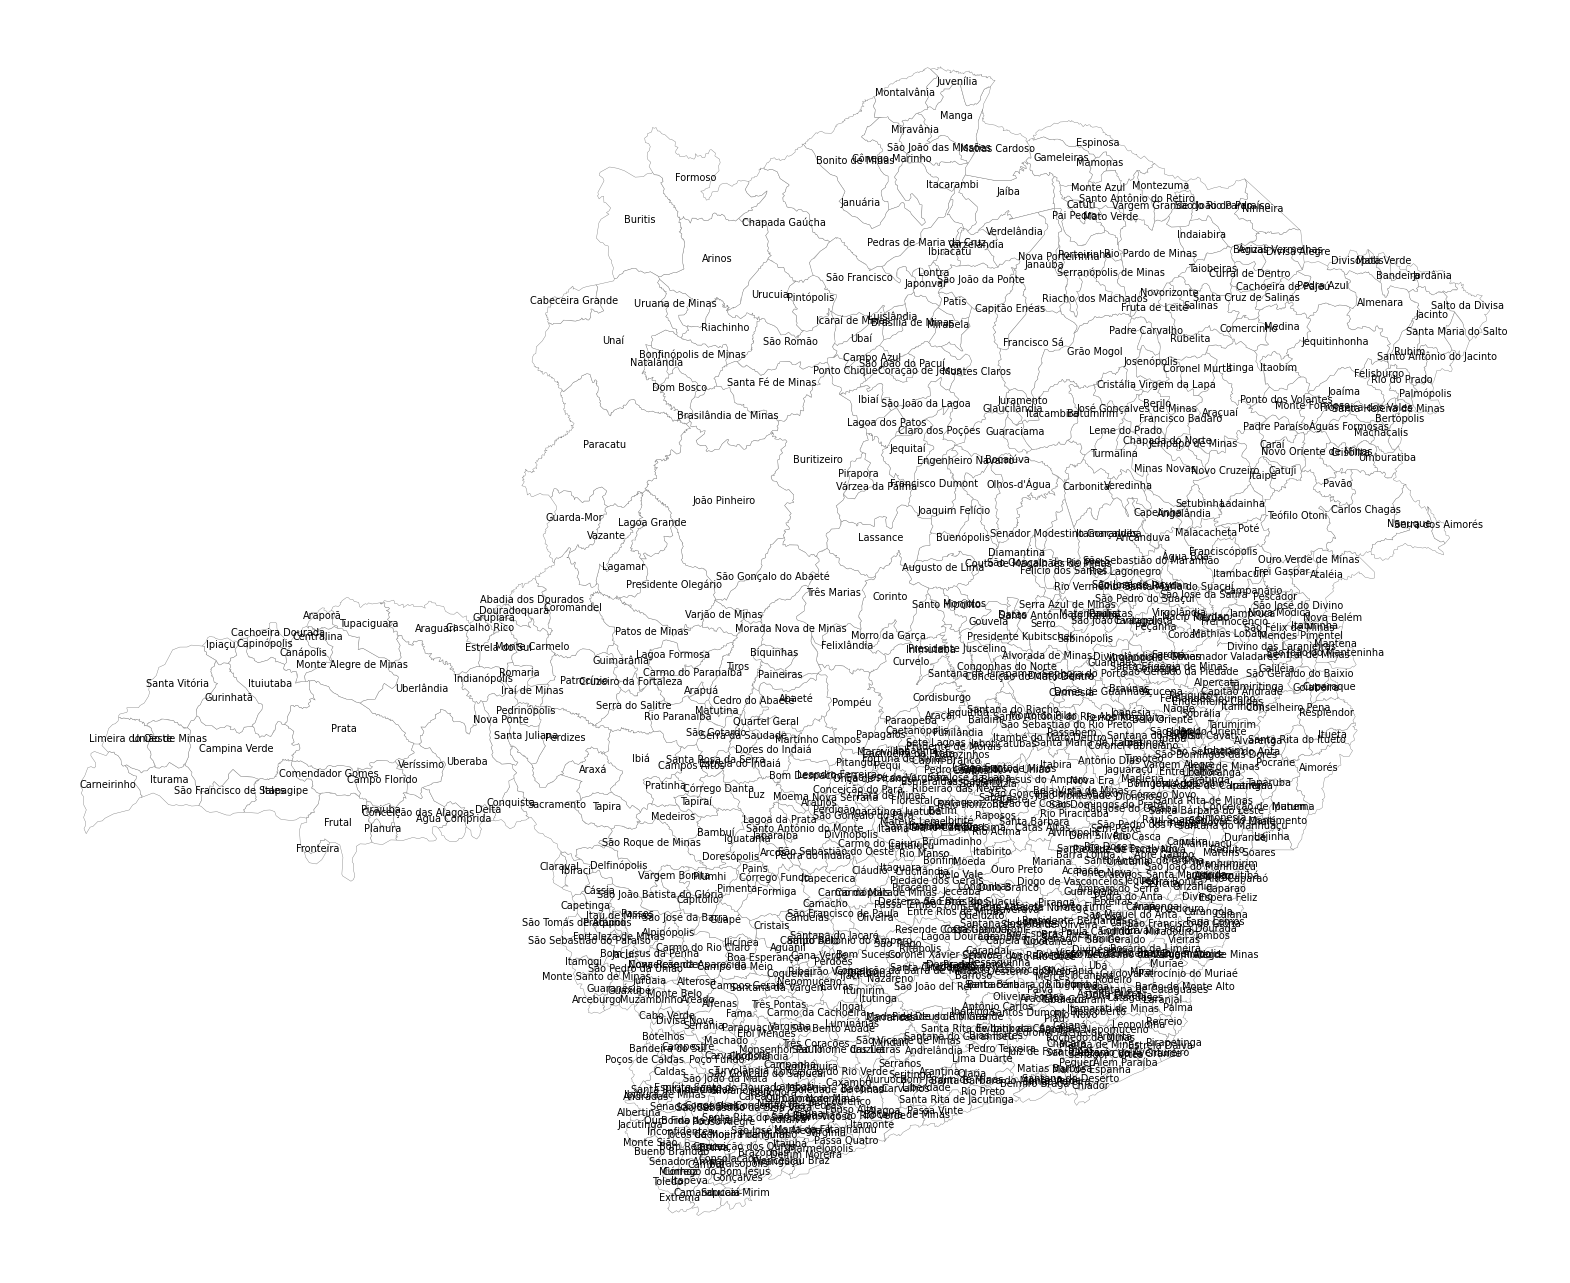

In [14]:
# plotar os nomes de todos os municípios
ax = mg.plot(figsize=(20, 20), color='white', linewidth=.3, edgecolor='gray')
ax.set_axis_off()
for i in mg.index:
    plt.text(mg.geometry.centroid[i].coords[0][0], mg.geometry.centroid[i].coords[0][1], mg.nome_mun[i],
             fontsize=7, horizontalalignment='center', verticalalignment='bottom')

In [15]:
# escolhendo algumas cidades manualmente
cidades_escolhidas = mg.query('nome_mun == ["Belo Horizonte", "Varginha", "Uberaba"]')

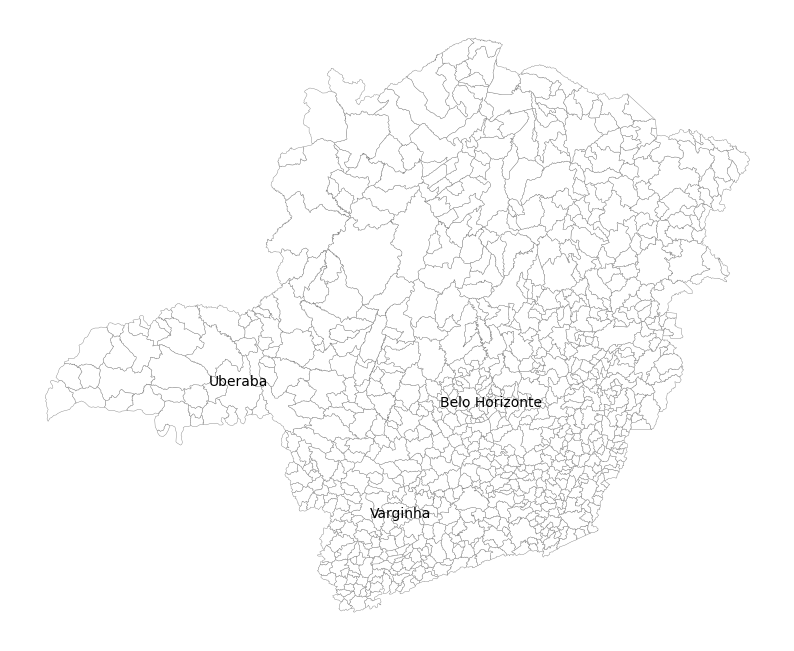

In [16]:
ax = mg.plot(figsize=(10, 10), color='white', linewidth=.3, edgecolor='gray')
ax.set_axis_off()
for i in cidades_escolhidas.index:
    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1],
             cidades_escolhidas.nome_mun[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

In [17]:
# pesquisa: municípios com mais de 200 mil habitantes
cidades_escolhidas = mg.query('popul >= 200000')
cidades_escolhidas.nome_mun.values

array(['Belo Horizonte', 'Betim', 'Contagem', 'Divinópolis',
       'Governador Valadares', 'Ipatinga', 'Juiz de Fora',
       'Montes Claros', 'Ribeirão das Neves', 'Santa Luzia',
       'Sete Lagoas', 'Uberaba', 'Uberlândia'], dtype=object)

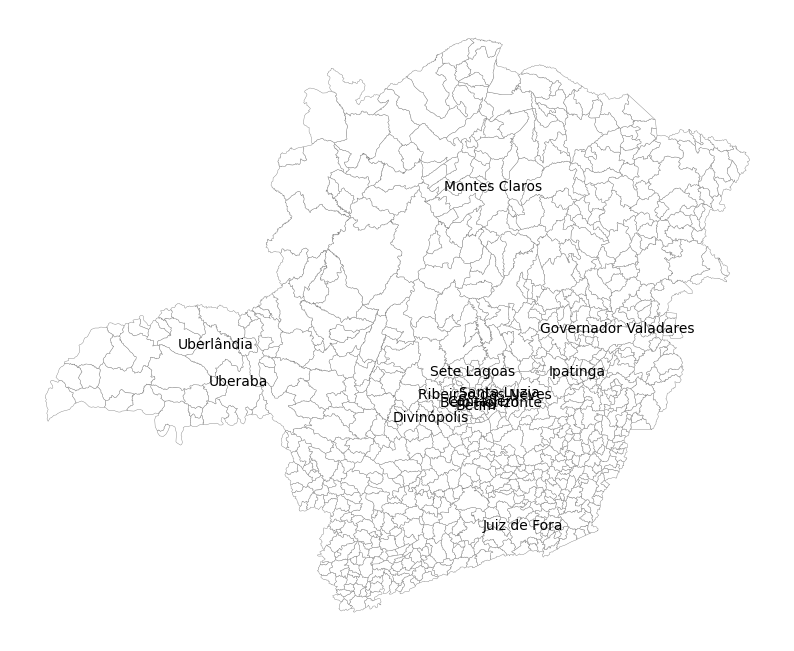

In [18]:
ax = mg.plot(figsize=(10, 10), color='white', linewidth=.3, edgecolor='gray')
ax.set_axis_off()
for i in cidades_escolhidas.index:
    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1],
             cidades_escolhidas.nome_mun[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

In [19]:
mg.columns

Index(['mun', 'geometry', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'popul', 'area', 'tot_f_meio_sm', 'tot_f_rdpc_154',
       'n_f_PBF', 'tot_benf_PBF', 'ex_cinema', 'ex_bib', 'n_bib',
       'tx_criancas_EF_adeq', 'tx_adol_EM_adeq', 'tx_EJA_EF_15m',
       'tx_EJA_EM_18m', 'tx_esc_0_3', 'tx_esc_15_17', 'n_esp_mun', 'gp_edu',
       'gp_agro', 'gp_total', 'percent_5', 'percent_6_17', 'percent_65',
       'percent_18_64_desemp', 'dens_pop', 'razao_dep', 'percent_ate_15',
       'transf_pc_PBF', 'n_emp_formal', 'rdpc_formal', 'tx_emp_form',
       'rm_form', 'tx_mort', 'tx_mort_homicidio', 'tx_mort_homicidio_15_29',
       'prop_priv_saude', 'percent_esgoto', 'percent_lixo', 'leite', 'ovos',
       'mel', 'banana_q', 'cafe_q', 'cana_q', 'feijao_q', 'milho_q', 'soja_q',
       'banana_v', 'cafe_v', 'cana_v', 'feijao_v', 'milho_v', 'soja_v',
       'banana_a', 'cafe_a', 'cana_a', 'feijao_a', 'milho_a', 'soja_a',
       'banana_p', 'cafe_p', 'cana_p', 'feijao_p', 'milh

In [20]:
variavel = 'rdpc_formal'

In [21]:
# escolhendo algumas cidades com critérios mais específicos
# aquelas com 5 maiores valores da variável
x = mg[variavel].sort_values(ascending=False).iloc[:5, ].index.values
pos = mg.loc[x, ['nome_mun']]
cidades_escolhidas = mg.iloc[pos.index, :]
cidades_escolhidas

,mun,geometry,nome_mun,meso,nome_meso,micro,nome_micro,popul,area,tot_f_meio_sm,...,cana_a,feijao_a,milho_a,soja_a,banana_p,cafe_p,cana_p,feijao_p,milho_p,soja_p
401,3135407,"POLYGON ((-4896546.321 -2318200.434, -4895506....",Jeceaba,3107,Metropolitana de Belo Horizonte,31032,Itaguara,5250,236.3,743,...,22,50,150,0,14000,1000,56000,900,4500,0
196,3117876,"POLYGON ((-4891921.787 -2219793.989, -4894037....",Confins,3107,Metropolitana de Belo Horizonte,31030,Belo Horizonte,6545,42.4,413,...,0,0,5,0,0,0,0,0,2000,0
798,3168101,"POLYGON ((-5212649.927 -2231899.854, -5210787....",Tapira,3105,Triângulo Mineiro/Alto Paranaíba,31023,Araxá,4598,1179.2,486,...,0,950,1500,1500,0,1800,0,2038,7800,3000
518,3144805,"POLYGON ((-4879597.818 -2249879.232, -4880328....",Nova Lima,3107,Metropolitana de Belo Horizonte,31030,Belo Horizonte,91069,429.1,3855,...,0,3,5,0,10000,2000,0,667,5000,0
65,3106200,"POLYGON ((-4892054.823 -2232209.608, -4891636....",Belo Horizonte,3107,Metropolitana de Belo Horizonte,31030,Belo Horizonte,2513451,331.4,119871,...,0,0,0,0,0,0,0,0,0,0


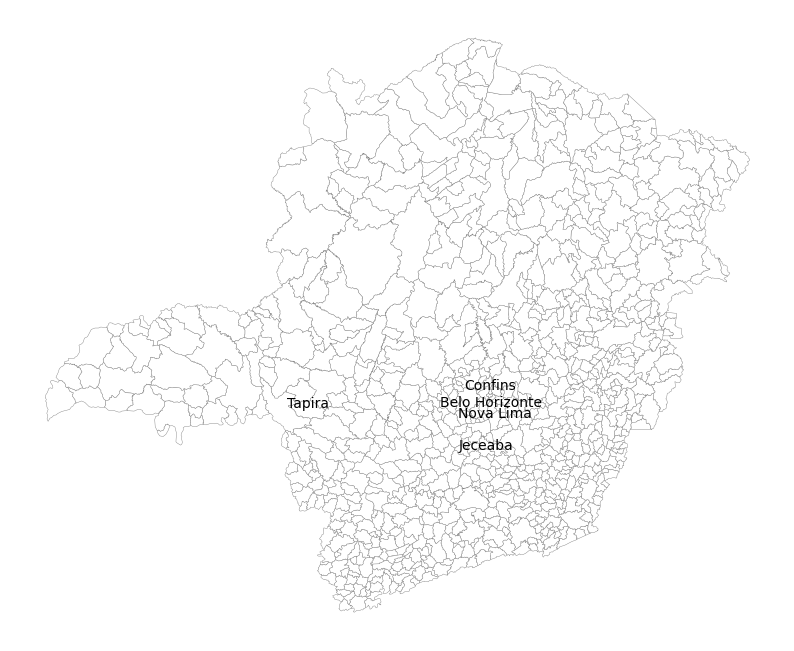

In [22]:
ax = mg.plot(figsize=(10, 10), color='white', linewidth=.3, edgecolor='gray')
ax.set_axis_off()
for i in cidades_escolhidas.index:
    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1],
             cidades_escolhidas.nome_mun[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

**Tarefa 1:**

Escolher municípios por 3 critérios diferentes e plotar os municípios que atendem a esses critérios.

## Parte 2  - sul de MG

In [23]:
ssm = mg.query('nome_meso == "Sul/Sudoeste de Minas"')

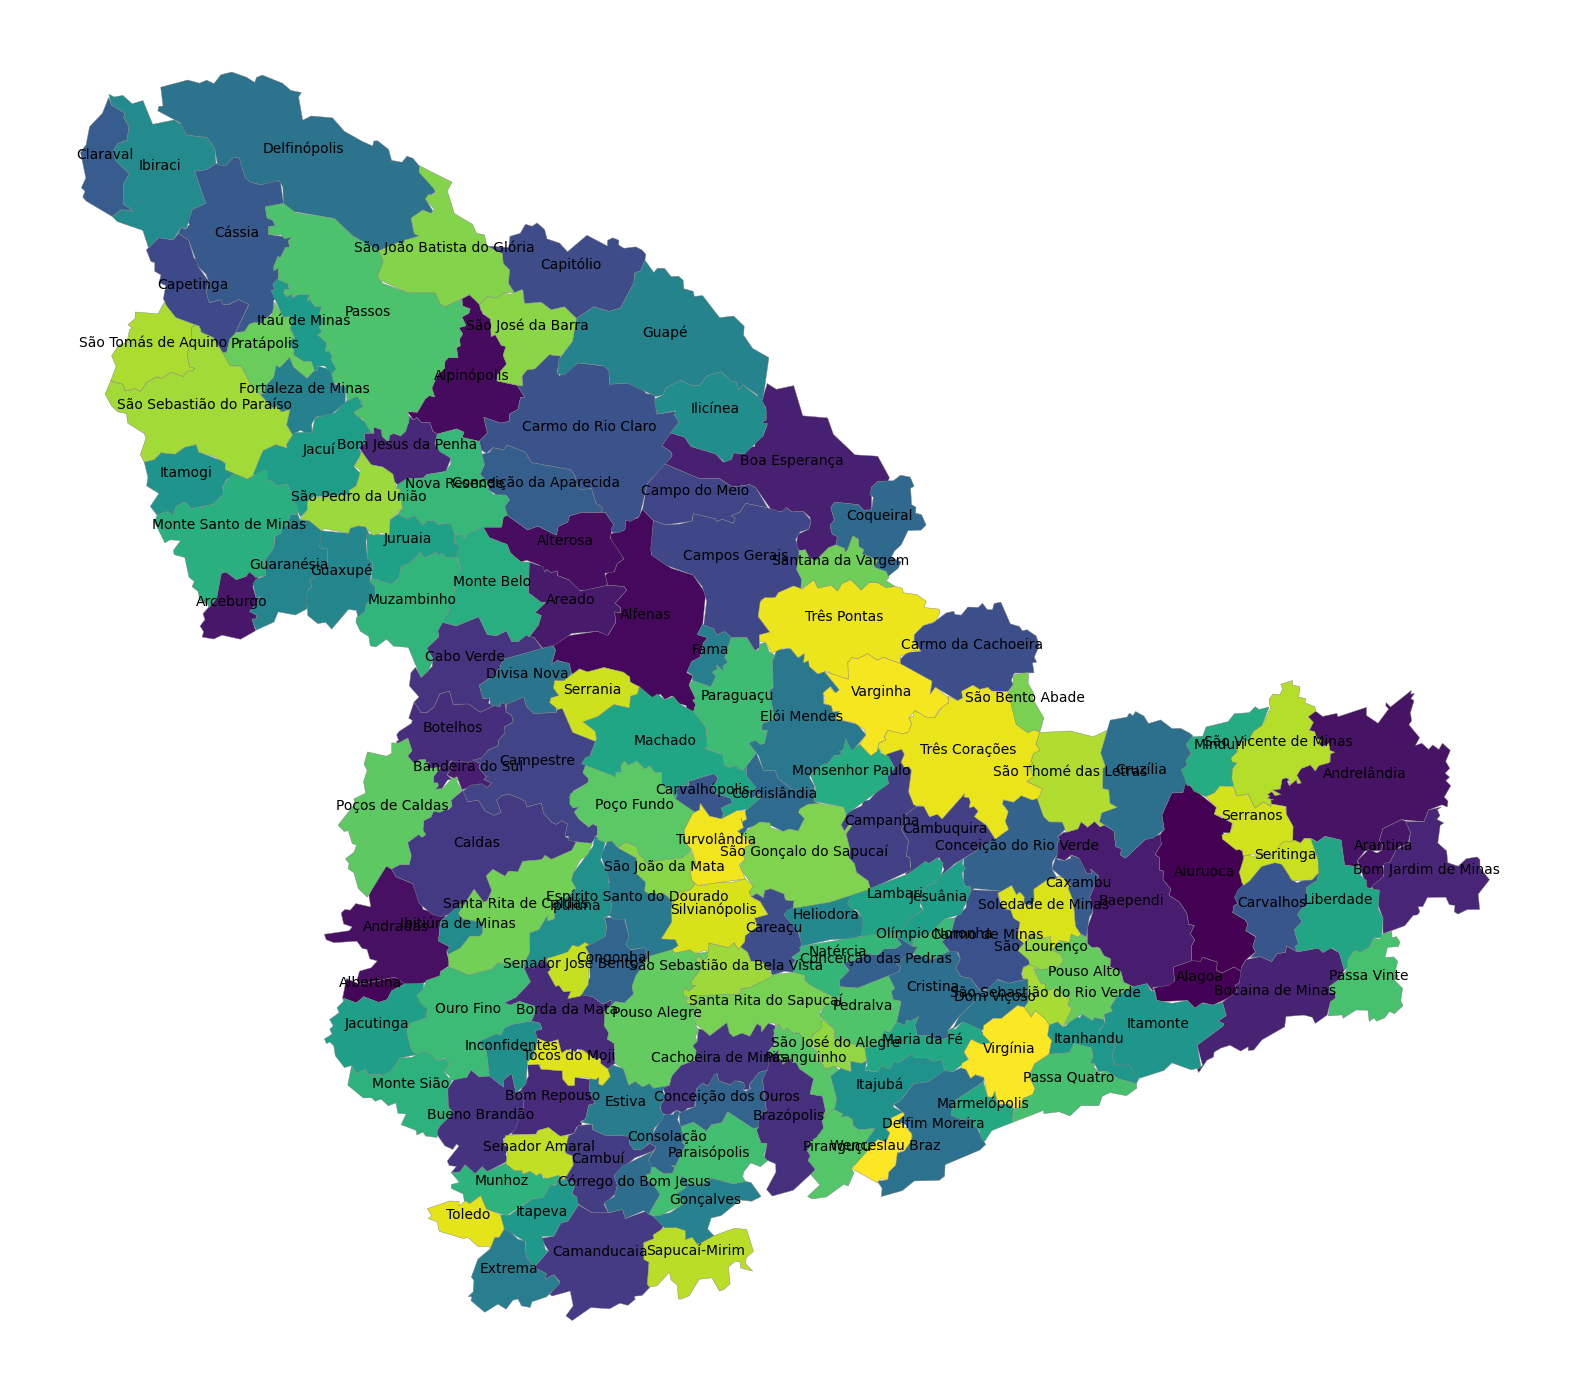

In [24]:
# mapa do sul de MG com nomes dos municípios
ax= ssm.plot(cmap='viridis', edgecolor='gray', linewidth=0.3, figsize=(20,20))

for i in ssm.index:

    plt.text(ssm.geometry.centroid[i].coords[0][0], ssm.geometry.centroid[i].coords[0][1], ssm.nome_mun[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

ax.set_axis_off();

In [25]:
# microrregiões do sul de MG
ssm.nome_micro.unique()

array(['Andrelândia', 'São Lourenço', 'Poços de Caldas', 'Alfenas',
       'Passos', 'São Sebastião do Paraíso', 'Varginha', 'Pouso Alegre',
       'Itajubá', 'Santa Rita do Sapucaí'], dtype=object)

**Tarefa 2**:

Escolher outra microrregião do sul de MG (menos Varginha) e apresentar o mapa com:

- os nomes dos municípios
- algum outro esquema de cores (basta escolher uma opção em https://matplotlib.org/stable/tutorials/colors/colormaps.html)

**Análise espacial - LISA**

Sul de Minas

In [ ]:
variavel

'rdpc_formal'

In [ ]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(ssm)
w.transform = 'r'

In [ ]:
# calcular I de Moran global para a variável escolhida
y = ssm[variavel].values
moran = Moran(y, w)
moran.I

0.06280449639457888

In [ ]:
# valor-p
moran.p_sim

0.132

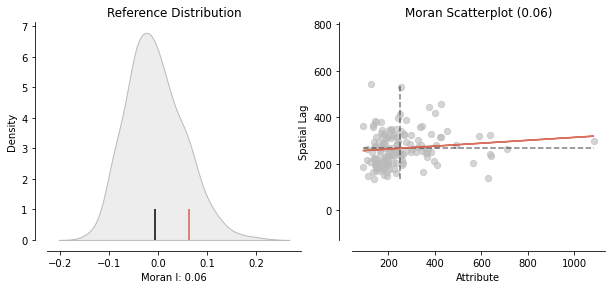

In [ ]:
# diagrama de dispersão de Moran
plot_moran(moran, zstandard=False, figsize=(10,4));

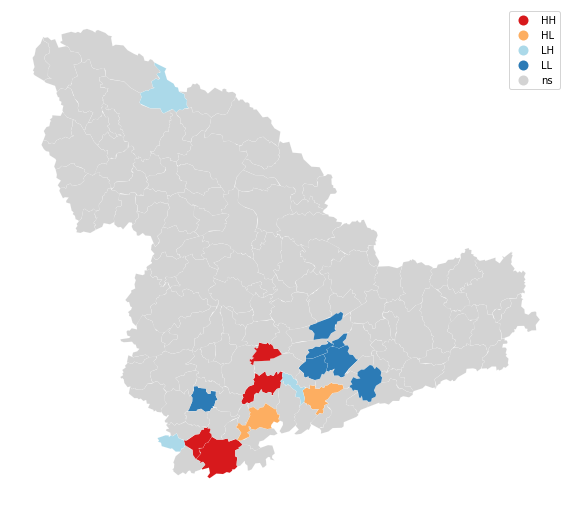

In [ ]:
lisa = Moran_Local(ssm[variavel], w)
lisa_cluster(lisa, ssm, p=0.05, legend=True, figsize=(10, 10));

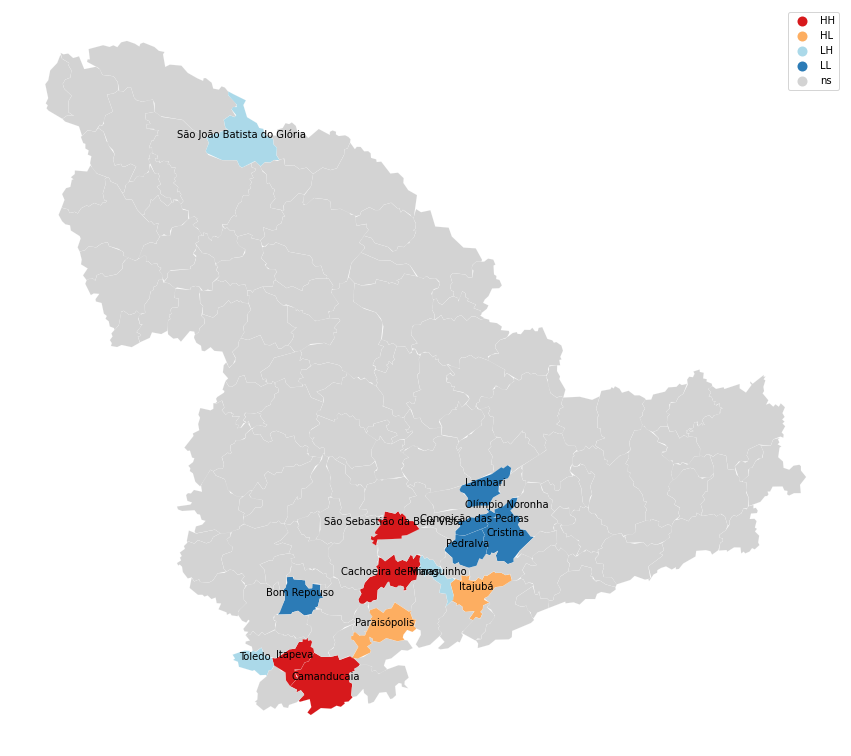

In [ ]:
# mostrar nomes dos significativos
# se precisar, aumentar tamanho da figura
import numpy as np
fig, ax = plt.subplots(1, figsize=(15, 15))
lisa = Moran_Local(ssm[variavel], w)
lisa_cluster(lisa, ssm, p=0.05, ax=ax, legend=True)
sig = lisa.p_sim < 0.05
posicoes = np.where(sig)
mun_escolhidos = ssm.iloc[posicoes[0]]
for j in mun_escolhidos.index:
    ax.text(mun_escolhidos.geometry.centroid[j].coords[0][0], mun_escolhidos.geometry.centroid[j].coords[0][1],
         mun_escolhidos.nome_mun[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')

**Tarefa 3:**

Escolher uma variável diferente da utilizada no exemplo e obter:
- *I* de Moran global e seu valor-*p*, informando se foi significativo e a interpretação
- mapa LISA com os nomes dos municípios significativos



**Tarefa 4:**

- Para o estado de MG inteiro, usar a mesma variável escolhida na tarefa 3 e efetuar a análise global e local
- Responder à pergunta: os municípios que foram significativos considerando apenas o sul de Minas foram os mesmos quando o estado inteiro foi considerado?

# Curiosidade

In [ ]:
# reiniciar índices
ssm = ssm.reset_index()

In [ ]:
# tentando identificar os municípios que são clusters espaciais e outliers espaciais
import numpy as np

In [ ]:
lisa.p_sim  # pseudovalores do LISA

array([0.258, 0.48 , 0.178, 0.141, 0.161, 0.286, 0.11 , 0.152, 0.316,
       0.166, 0.149, 0.359, 0.3  , 0.151, 0.21 , 0.086, 0.243, 0.014,
       0.379, 0.155, 0.385, 0.244, 0.485, 0.01 , 0.133, 0.007, 0.431,
       0.32 , 0.263, 0.136, 0.141, 0.214, 0.309, 0.093, 0.095, 0.138,
       0.236, 0.45 , 0.248, 0.131, 0.259, 0.423, 0.313, 0.105, 0.028,
       0.406, 0.406, 0.125, 0.132, 0.376, 0.293, 0.093, 0.047, 0.45 ,
       0.42 , 0.288, 0.298, 0.256, 0.098, 0.095, 0.149, 0.186, 0.102,
       0.203, 0.183, 0.092, 0.144, 0.255, 0.318, 0.446, 0.163, 0.478,
       0.346, 0.119, 0.001, 0.16 , 0.268, 0.155, 0.013, 0.39 , 0.331,
       0.297, 0.18 , 0.112, 0.021, 0.068, 0.487, 0.356, 0.304, 0.484,
       0.082, 0.148, 0.155, 0.393, 0.253, 0.057, 0.221, 0.284, 0.032,
       0.403, 0.258, 0.022, 0.395, 0.07 , 0.414, 0.001, 0.093, 0.048,
       0.286, 0.121, 0.328, 0.243, 0.217, 0.481, 0.467, 0.473, 0.137,
       0.342, 0.029, 0.218, 0.452, 0.341, 0.396, 0.197, 0.009, 0.24 ,
       0.309, 0.108,

In [ ]:
sig = lisa.p_sim < 0.05  # identificar significativos
sig

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False,

In [ ]:
# quais os valores-p significativos
lisa.p_sim[sig]

array([0.014, 0.01 , 0.007, 0.028, 0.047, 0.001, 0.013, 0.021, 0.032,
       0.022, 0.001, 0.048, 0.029, 0.009, 0.005])

In [ ]:
# quadrantes de todos os municípios
lisa.q

array([3, 3, 2, 4, 2, 2, 1, 3, 3, 1, 2, 2, 3, 4, 3, 3, 3, 3, 2, 2, 3, 3,
       3, 1, 1, 1, 4, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 3, 1, 3, 2, 1, 2, 2, 2, 2,
       1, 1, 2, 4, 2, 3, 3, 3, 4, 2, 1, 1, 1, 1, 2, 1, 3, 1, 3, 3, 4, 3,
       3, 3, 1, 4, 2, 4, 3, 1, 2, 3, 3, 1, 1, 4, 4, 3, 1, 3, 2, 2, 3, 1,
       1, 1, 2, 4, 3, 4, 2, 4, 2, 3, 4, 2, 4, 2, 1, 4, 2, 2, 1, 4, 1, 3,
       3, 3, 2, 3, 1, 2, 3, 2, 1, 1, 3, 1, 3, 2])

In [ ]:
# identificar os quadrantes dos significativos
lisa.q[sig]

array([3, 1, 1, 3, 3, 4, 1, 3, 3, 4, 3, 2, 2, 1, 2])

In [ ]:
# posições dos municípios significativos
posicoes = np.where(sig)
posicoes

(array([ 17,  23,  25,  44,  52,  74,  78,  84,  98, 101, 105, 107, 118,
        124, 139]),)

In [ ]:
posicoes[0]   # apenas o array com as posições

array([ 17,  23,  25,  44,  52,  74,  78,  84,  98, 101, 105, 107, 118,
       124, 139])

In [ ]:
# pegando a informação sobre o quadrante de cada município para criar novo dataframe
ssm['quad'] = lisa.q

In [ ]:
# mostrando apenas os significativos
ssm.loc[posicoes[0], ['nome_mun', 'quad']]
# se quiséssemos algum quadrante específico: LL(1), LH(2), HH(3), HL(4)
ssm.loc[posicoes[0], ['nome_mun', 'quad']].query('quad == 4')

,nome_mun,quad
74,Itajubá,4
101,Paraisópolis,4
